In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

In [46]:
def fun_max6(df):
    """Create a new column "good_quality" as the dependent variable. 
    If the quality score is above 6, then it's marked as 1.
    Otherwise, marked as 0.
    """
    df['good_quality'] = 0
    a = df.shape[0]
    for i in range(a):
        if df.loc[i, 'quality'] > 6:
            df.loc[i, 'good_quality'] = 1

In [47]:
from google.colab import files
uploaded = files.upload()

Saving wine.csv to wine (3).csv


In [48]:
# read the original dataset, and add a new column to it
filename ="wine.csv"
df = pd.read_csv(filename)
fun_max6(df)

In [49]:
df.head()

fixed_acidity  volatile_acidity  citric_acid  ...  quality  style  good_quality
0            7.0              0.27         0.36  ...        6  white             0
1            6.3              0.30         0.34  ...        6  white             0
2            8.1              0.28         0.40  ...        6  white             0
3            7.2              0.23         0.32  ...        6  white             0
4            7.2              0.23         0.32  ...        6  white             0

[5 rows x 14 columns]

In [50]:
rvar_list =['quality']
df_sample1 = df.drop(columns=rvar_list)

nvar_list = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 
             'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 
  'sulphates', 'alcohol']
cvar_list = ['good_quality']

In [51]:
df_sample3 = df_sample1.copy()
df_sample3[cvar_list] = df_sample1[cvar_list].astype('category')
df_sample3[nvar_list] = df_sample1[nvar_list].astype('float64')

In [52]:
# Required package: scikit-learn. Package name in Python: sklearn
# Required subpackage: model_selection. Required function name: train_test_split
from sklearn.model_selection import train_test_split

# Placeholder variables: df4partition, testpart_size
# test_size specifies the percentage for the test partition
df4partition = df_sample3
testpart_size = 0.2

# random_state specifies the seed for random number generator. 
# random_state = 1 unless otherwised noted
df_nontestData, df_testData = train_test_split(df4partition, test_size=testpart_size, random_state=1)

In [53]:
# Part 6 Classification tree 

# Required package: scikit-learn. Package name in Python: sklearn
# Required subpackage: tree 
# Required function name: DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier


# Separate the predictor values and the DV values into X and y respectively
# Placeholder variable: DV
DV = 'good_quality'
y = df_nontestData[DV]
X = df_nontestData.drop(columns=[DV])

from sklearn.tree import export_graphviz
from io import StringIO
import pydotplus
from IPython.display import Image

# A user-defined function summary_tree to display a classification tree
def summary_tree(model_object):
  dot_data = StringIO()
  export_graphviz(model_object, out_file=dot_data, filled=True,
                  rounded=True, special_characters=True, feature_names=X.columns.values,
                  class_names=['0', '1'])
  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  output_imagefile = 'tree.png'
  graph.write_png(output_imagefile)
  return output_imagefile



## AUC

In [ ]:
kfolds = 5

# Here we specify within which range of depths we will search for the best pruned tree
kfolds = 5

# Here we specify within which range of depths we will search for the best pruned tree
maximum_depth = 100
minimum_depth = 1

param_grid = {'max_depth': list(range(minimum_depth, maximum_depth+1))}



from sklearn.model_selection import GridSearchCV

gridsearch = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=1), param_grid, scoring='roc_auc', cv=kfolds, n_jobs=-1)
gridsearch.fit(X,y)
clf_BPT = gridsearch.best_estimator_

# Display the resulting best pruned tree
Image(summary_tree(clf_BPT))

In [ ]:
# Display the level of depth of the best pruned tree
print(clf_BPT.get_depth())

# y_test_actual is the actual values of the DV in the test partition
y_test_actual = df_testData[DV]

# X_test is the predictor values in the test partition
X_test = df_testData.drop(columns=[DV])


# Get the AUC of the best pruned tree model
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test_actual, clf_BPT.predict_proba(X_test)[:,1]))

NameError: ignored

In [ ]:
import numpy as np

# The user-defined function for getting the tree path
# Author: Federico Ibba on stackoverflow.com 
# Created date: Jan 19, 2018
# URL: https://stackoverflow.com/questions/32506951/how-to-explore-a-decision-tree-built-using-scikit-learn/35911666
# Modified by Lin Hao during Oct. 2020

def get_treepaths(dtc, df):
    rules_list = []
    values_path = []
    values = dtc.tree_.value

    def RevTraverseTree(tree, node, rules, pathValues):
        try:
            prevnode = tree[2].index(node)           
            leftright = '<='
            pathValues.append(values[prevnode])
        except ValueError:
            # failed, so find it as a right node - if this also causes an exception, something's really f'd up
            prevnode = tree[3].index(node)
            leftright = '>'
            pathValues.append(values[prevnode])

        # now let's get the rule that caused prevnode to -> node
        p1 = df.columns[tree[0][prevnode]]    
        p2 = tree[1][prevnode]    
        rules.append(str(p1) + ' ' + leftright + ' ' + str(p2))

        # if we've not yet reached the top, go up the tree one more step
        if prevnode != 0:
            RevTraverseTree(tree, prevnode, rules, pathValues)

    # get the nodes which are leaves
    leaves = dtc.tree_.children_left == -1
    leaves = np.arange(0,dtc.tree_.node_count)[leaves]

    # build a simpler tree as a nested list: [split feature, split threshold, left node, right node]
    thistree = [dtc.tree_.feature.tolist()]
    thistree.append(dtc.tree_.threshold.tolist())
    thistree.append(dtc.tree_.children_left.tolist())
    thistree.append(dtc.tree_.children_right.tolist())

    # get the decision rules for each leaf node & apply them
    for (ind,nod) in enumerate(leaves):

        # get the decision rules
        rules = []
        pathValues = []
        RevTraverseTree(thistree, nod, rules, pathValues)

        pathValues.insert(0, values[nod])      
        pathValues = list(reversed(pathValues))

        rules = list(reversed(rules))

        rules_list.append(rules)
        values_path.append(pathValues)

    for i in range(len(rules_list)):
      
      print('\nLeaf node ID =', i+1)
      print('Path =', rules_list[i])
      distro = sum(values_path[i][-1])
      print('sample =', int(sum(distro)))
      print('value =', list([int(distro[0]), int(distro[1])]))
      predicted_class = 1 if distro[1] > distro[0] else 0
      print('class = ', predicted_class)
      
    return None

get_treepaths(dtc=clf_BPT, df=df_nontestData)



Leaf node ID = 1
Path = ['alcohol <= 10.625', 'volatile_acidity <= 0.20250000059604645', 'density <= 0.9978799819946289', 'sulphates <= 0.8149999976158142', 'alcohol <= 10.050000190734863']
sample = 239
value = [217, 22]
class =  0

Leaf node ID = 2
Path = ['alcohol <= 10.625', 'volatile_acidity <= 0.20250000059604645', 'density <= 0.9978799819946289', 'sulphates <= 0.8149999976158142', 'alcohol > 10.050000190734863']
sample = 167
value = [131, 36]
class =  0

Leaf node ID = 3
Path = ['alcohol <= 10.625', 'volatile_acidity <= 0.20250000059604645', 'density <= 0.9978799819946289', 'sulphates > 0.8149999976158142']
sample = 5
value = [0, 5]
class =  1

Leaf node ID = 4
Path = ['alcohol <= 10.625', 'volatile_acidity <= 0.20250000059604645', 'density > 0.9978799819946289', 'citric_acid <= 0.3050000071525574', 'alcohol <= 9.150000095367432']
sample = 47
value = [2, 45]
class =  1

Leaf node ID = 5
Path = ['alcohol <= 10.625', 'volatile_acidity <= 0.20250000059604645', 'density > 0.99787998

## Accuracy

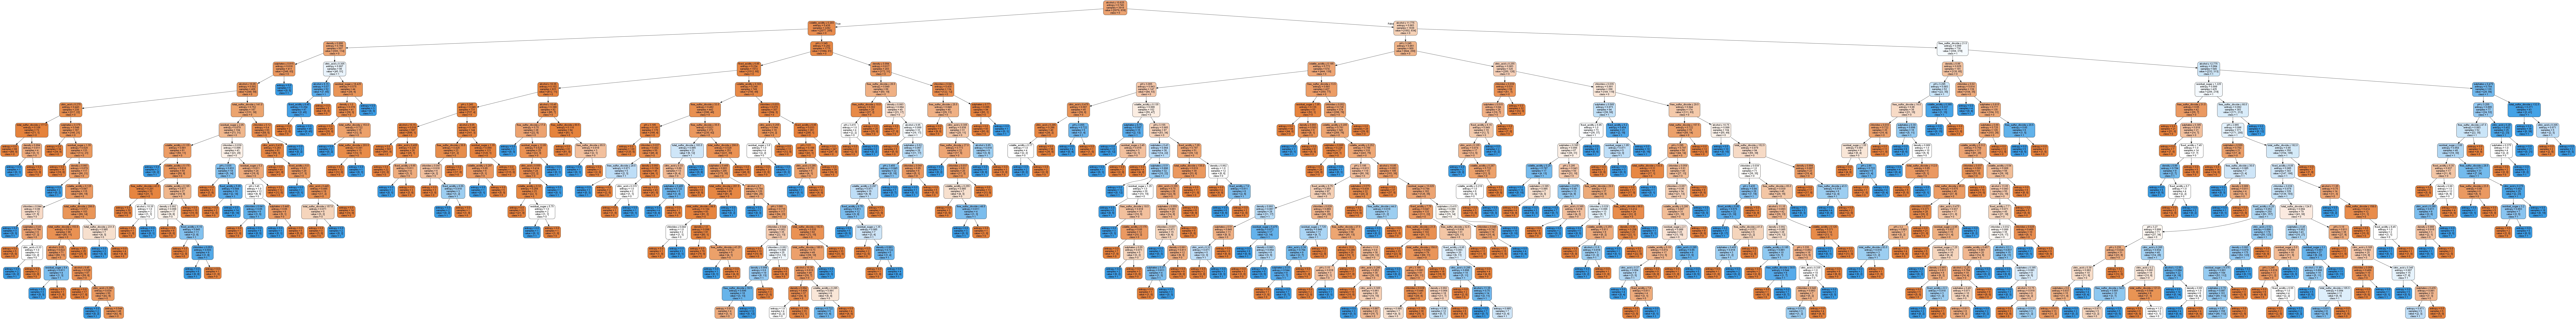

In [ ]:
gridsearch = GridSearchCV(DecisionTreeClassifier(criterion='entropy', random_state=1), param_grid, scoring='accuracy', cv=kfolds, n_jobs=-1)
gridsearch.fit(X,y)
clf_BPT = gridsearch.best_estimator_

# Display the resulting best pruned tree
Image(summary_tree(clf_BPT))

In [ ]:
# Display the level of depth of the best pruned tree
print(clf_BPT.get_depth())

# y_test_actual is the actual values of the DV in the test partition
y_test_actual = df_testData[DV]

# X_test is the predictor values in the test partition
X_test = df_testData.drop(columns=[DV])


15


In [ ]:
from sklearn import metrics
metrics.confusion_matrix(y_test_actual, clf_BPT.predict(X_test))

array([[675,  84],
       [ 84, 137]], dtype=int64)

In [ ]:
clf_BPT.score(X_test, y_test_actual )

0.8285714285714286

In [ ]:
get_treepaths(dtc=clf_BPT, df=df_nontestData)


Leaf node ID = 1
Path = ['alcohol <= 10.625', 'volatile_acidity <= 0.20250000059604645', 'density <= 0.9978799819946289', 'sulphates <= 0.8149999976158142', 'alcohol <= 10.050000190734863', 'citric_acid <= 0.2750000059604645', 'total_sulfur_dioxide <= 177.0']
sample = 68
value = [68, 0]
class =  0

Leaf node ID = 2
Path = ['alcohol <= 10.625', 'volatile_acidity <= 0.20250000059604645', 'density <= 0.9978799819946289', 'sulphates <= 0.8149999976158142', 'alcohol <= 10.050000190734863', 'citric_acid <= 0.2750000059604645', 'total_sulfur_dioxide > 177.0', 'density <= 0.9940600097179413']
sample = 1
value = [0, 1]
class =  1

Leaf node ID = 3
Path = ['alcohol <= 10.625', 'volatile_acidity <= 0.20250000059604645', 'density <= 0.9978799819946289', 'sulphates <= 0.8149999976158142', 'alcohol <= 10.050000190734863', 'citric_acid <= 0.2750000059604645', 'total_sulfur_dioxide > 177.0', 'density > 0.9940600097179413']
sample = 3
value = [3, 0]
class =  0

Leaf node ID = 4
Path = ['alcohol <= 10.

class =  0

Leaf node ID = 208
Path = ['alcohol > 10.625', 'alcohol <= 11.775000095367432', 'pH > 3.2450000047683716', 'citric_acid > 0.2549999952316284', 'chlorides <= 0.035499999299645424', 'sulphates <= 0.5649999976158142', 'fixed_acidity <= 6.950000047683716', 'sulphates > 0.39499999582767487', 'pH <= 3.2949999570846558', 'sulphates > 0.4749999940395355', 'citric_acid > 0.36500000953674316']
sample = 2
value = [0, 2]
class =  1

Leaf node ID = 209
Path = ['alcohol > 10.625', 'alcohol <= 11.775000095367432', 'pH > 3.2450000047683716', 'citric_acid > 0.2549999952316284', 'chlorides <= 0.035499999299645424', 'sulphates <= 0.5649999976158142', 'fixed_acidity <= 6.950000047683716', 'sulphates > 0.39499999582767487', 'pH > 3.2949999570846558', 'free_sulfur_dioxide <= 29.5', 'chlorides <= 0.02850000001490116']
sample = 5
value = [0, 5]
class =  1

Leaf node ID = 210
Path = ['alcohol > 10.625', 'alcohol <= 11.775000095367432', 'pH > 3.2450000047683716', 'citric_acid > 0.2549999952316284', 